In [10]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Set up the WebDriver options
options = Options()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

# Initialize WebDriver
service = Service("C:\\Users\\ASUS\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")  # Update with your path
driver = webdriver.Chrome(service=service, options=options)

# IMDb Top 250 URL
top_250_url = "https://www.imdb.com/chart/top/"

# Open the URL
driver.get(top_250_url)

# Wait for the page to load and movie links to appear
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "ul.ipc-metadata-list li")))

# Parse HTML with BeautifulSoup
soup = BeautifulSoup(driver.page_source, "html.parser")
print(driver.page_source[:1000])  # Prints the first 1000 characters of the page source

# Extract movie links - Update the selector based on inspection of the page
movies = soup.select("ul.ipc-metadata-list li a.ipc-title-link-wrapper")  # Update this selector
movie_links = ["https://www.imdb.com" + movie["href"] for movie in movies]

# Limit to first 10 movies for testing
movie_links = movie_links[:250]
print(f"Scraping {len(movie_links)} movie links...")
print(movie_links[:250])  # Display the first 5 links

# Initialize list for data
movies_data = []

# Loop through each movie link
for index, link in enumerate(movie_links):
    driver.get(link)
    time.sleep(1)  # Allow page to load
    
    # Wait for the title to load on the movie page
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1")))

    movie_soup = BeautifulSoup(driver.page_source, "html.parser")

    # Extract movie details
    try:
        # Title
        title = movie_soup.find("h1").text.strip() if movie_soup.find("h1") else "N/A"

        # Year
        year = movie_soup.select_one("ul.ipc-inline-list li a[href*='releaseinfo']").text.strip() if movie_soup.select_one("ul.ipc-inline-list li a[href*='releaseinfo']") else "N/A"

        # Rating (wait for dynamic content)
        try:
            # Wait for the rating to be fully visible
            rating_element = WebDriverWait(driver, 10).until(
                EC.visibility_of_element_located((By.CSS_SELECTOR, "span.sc-d541859f-1.imUuxf"))  # Check actual class from IMDb
            )
            rating = rating_element.text.strip()
        except Exception as e:
            print(f"Error finding rating: {e}")
            rating = "N/A"


        # Genres
        genre_tags = movie_soup.select("div.ipc-chip-list a span")
        genres = ", ".join([g.text for g in genre_tags]) if genre_tags else "N/A"

        # Directors
        # Wait for the director's element to be visible
        try:
            director_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div.sc-70a366cc-3.iwmAOx > div > ul > li:nth-child(1) > div > ul > li > a"))
            )
            
            # Get the current director's name
            current_director = director_element.text.strip()
            print(f"Current Director: {current_director}")

            # Modify the director's name (for testing, we use JavaScript)
            driver.execute_script("arguments[0].innerText = 'New Director Name';", director_element)

            print("✅ Director's name edited successfully!")

        except Exception as e:
            print(f"Error locating director: {e}")

                
        # Limit to top 3 actors (if available)
        # Wait for actors section to be present
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.sc-70a366cc-3.iwmAOx > div > ul > li:nth-child(3) > div > ul > li > a"))
            )

            # Extract actor names using BeautifulSoup
            actor_elements = driver.find_elements(By.XPATH, "//li[contains(@class, 'ipc-metadata-list__item')][3]//ul/li/a")
            actors = ", ".join([actor.text.strip() for actor in actor_elements[:3]]) if actor_elements else "N/A"


            print(f"🎭 Lead Actors: {actors}")

        except Exception as e:
            print(f"❌ Error extracting actors: {e}")

        
        # Box office revenue (optional)
        try:
            # Wait for the box office section to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//li[contains(@class, 'ipc-metadata-list__item')]//span[contains(text(), 'Gross worldwide')]"))
            )

            # Find the label "Gross worldwide"
            box_office_label = driver.find_element(By.XPATH, "//li[contains(@class, 'ipc-metadata-list__item')]//span[contains(text(), 'Gross worldwide')]")
            
            # Extract the revenue value next to the label
            box_office_value = box_office_label.find_element(By.XPATH, "./following-sibling::div//span").text.strip()
            box_office = box_office_value

            print(f"💰 Box Office Revenue: {box_office}")

        except Exception as e:
            print(f"❌ Error extracting revenue: {e}")
            box_office = "N/A"


        # Save data
        movies_data.append({
            "Title": title,
            "Year": year,
            "IMDb Rating": rating,
            "Genre": genres,
            "Director(s)": current_director,
            "Lead Actors": actors,
            "Box Office Revenue": box_office
        })

        print(f"Scraped {index+1}: {title} ({year}) - Rating: {rating}")

    except Exception as e:
        print(f"Error scraping movie {index+1}: {e}")

# Close the Selenium driver
driver.quit()

# Save to CSV
df = pd.DataFrame(movies_data)
df.to_csv("imdb_top_250.csv", index=False)

print("\n✅ IMDb Top 250 Movies Scraped Successfully! Data saved to 'imdb_top_250.csv'")

<html lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://www.facebook.com/2008/fbml" class=" scriptsOn"><head><script async="" src="https://images-na.ssl-images-amazon.com/images/I/216YVwoRFDL.js" crossorigin="anonymous"></script><meta charset="utf-8"><meta name="viewport" content="width=device-width"><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><title>IMDb Top 250 Movies</title><meta name="description" content="As rated by regular IMDb voters." data-id="main"><meta name="robots" content="max-image-preview:large"><meta property="og:url" content="https://www.imdb.com/chart/top/"><meta property="og:site_name" content="IMDb"><meta property="og:title" content="IMDb Top 250 Movies"><meta property="og:description" content="As rated by regular IMDb voters."><meta property="og:type" content="website"><meta property="og:image" content="https://m.media-amazon.com/images/G/01/imdb/images/social/imdb_logo.png"><meta property="og:image

In [11]:
import pandas as pd

# Load the data
df = pd.read_csv("imdb_top_250.csv")

# Display the first few rows
print(df.head())

                      Title  Year  IMDb Rating  \
0  The Shawshank Redemption  1994          9.3   
1             The Godfather  1972          9.2   
2           The Dark Knight  2008          9.0   
3     The Godfather Part II  1974          9.0   
4              12 Angry Men  1957          9.0   

                                               Genre           Director(s)  \
0            Epic, Period Drama, Prison Drama, Drama        Frank Darabont   
1              Epic, Gangster, Tragedy, Crime, Drama  Francis Ford Coppola   
2  Action Epic, Epic, Superhero, Tragedy, Action,...     Christopher Nolan   
3              Epic, Gangster, Tragedy, Crime, Drama  Francis Ford Coppola   
4     Legal Drama, Psychological Drama, Crime, Drama          Sidney Lumet   

                                   Lead Actors Box Office Revenue  
0      Tim Robbins, Morgan Freeman, Bob Gunton        $29,332,133  
1         Marlon Brando, Al Pacino, James Caan       $250,342,198  
2  Christian Bale, Heath L

In [12]:
# Clean the Box Office Revenue column
df['Box Office Revenue'] = df['Box Office Revenue'].replace('[\$,]', '', regex=True).replace('N/A', pd.NA).astype(float)

# Clean the IMDb Rating column
df['IMDb Rating'] = df['IMDb Rating'].replace('N/A', pd.NA).astype(float)

# Clean the Year column
df['Year'] = df['Year'].replace('N/A', pd.NA).astype(float)

# Drop rows with missing values (optional)
df = df.dropna()

# Display cleaned data
print(df.head())

                      Title    Year  IMDb Rating  \
0  The Shawshank Redemption  1994.0          9.3   
1             The Godfather  1972.0          9.2   
2           The Dark Knight  2008.0          9.0   
3     The Godfather Part II  1974.0          9.0   
4              12 Angry Men  1957.0          9.0   

                                               Genre           Director(s)  \
0            Epic, Period Drama, Prison Drama, Drama        Frank Darabont   
1              Epic, Gangster, Tragedy, Crime, Drama  Francis Ford Coppola   
2  Action Epic, Epic, Superhero, Tragedy, Action,...     Christopher Nolan   
3              Epic, Gangster, Tragedy, Crime, Drama  Francis Ford Coppola   
4     Legal Drama, Psychological Drama, Crime, Drama          Sidney Lumet   

                                   Lead Actors  Box Office Revenue  
0      Tim Robbins, Morgan Freeman, Bob Gunton        2.933213e+07  
1         Marlon Brando, Al Pacino, James Caan        2.503422e+08  
2  Christia

In [13]:
# Descriptive statistics for IMDb Rating
rating_stats = df['IMDb Rating'].describe()
print("IMDb Rating Statistics:")
print(rating_stats)

# Descriptive statistics for Box Office Revenue
revenue_stats = df['Box Office Revenue'].describe()
print("\nBox Office Revenue Statistics:")
print(revenue_stats)

# Descriptive statistics for Year
year_stats = df['Year'].describe()
print("\nYear Statistics:")
print(year_stats)

IMDb Rating Statistics:
count    246.000000
mean       8.309350
std        0.232717
min        8.000000
25%        8.100000
50%        8.200000
75%        8.400000
max        9.300000
Name: IMDb Rating, dtype: float64

Box Office Revenue Statistics:
count    2.460000e+02
mean     2.297103e+08
std      3.710648e+08
min      3.990000e+02
25%      7.535690e+06
50%      6.251449e+07
75%      3.216797e+08
max      2.799439e+09
Name: Box Office Revenue, dtype: float64

Year Statistics:
count     246.000000
mean     1987.939024
std        25.510469
min      1921.000000
25%      1971.250000
50%      1995.000000
75%      2008.000000
max      2024.000000
Name: Year, dtype: float64


In [14]:
# Group by Year and calculate mean revenue and rating
trends = df.groupby('Year').agg({
    'Box Office Revenue': 'mean',
    'IMDb Rating': 'mean'
}).reset_index()

# Display trends
print(trends)

      Year  Box Office Revenue  IMDb Rating
0   1921.0        4.197900e+04     8.200000
1   1924.0        3.990000e+02     8.200000
2   1925.0        3.149000e+04     8.100000
3   1926.0        1.344000e+03     8.100000
4   1927.0        1.350322e+06     8.300000
..     ...                 ...          ...
80  2020.0        2.404894e+07     8.200000
81  2021.0        9.763998e+08     8.350000
82  2022.0        1.495696e+09     8.200000
83  2023.0        5.555915e+08     8.533333
84  2024.0        2.708448e+08     8.375000

[85 rows x 3 columns]


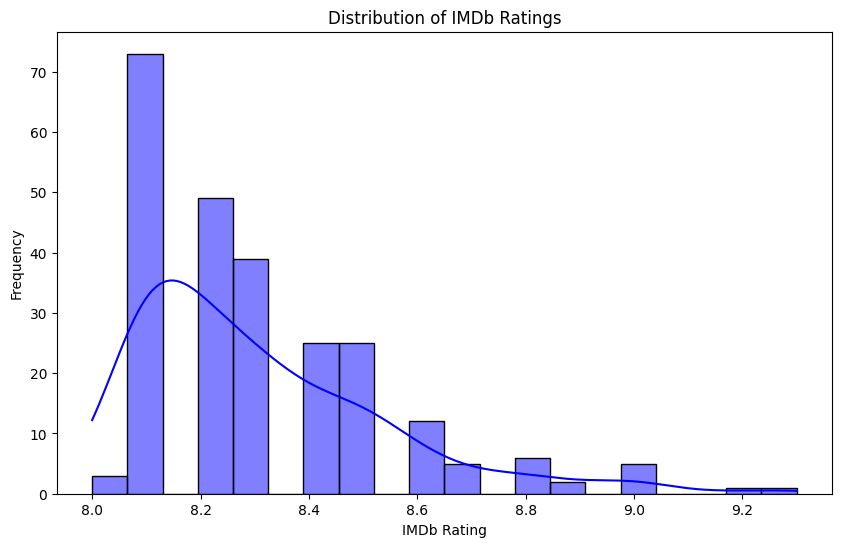

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of IMDb Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDb Rating'], bins=20, kde=True, color='blue')
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.show()

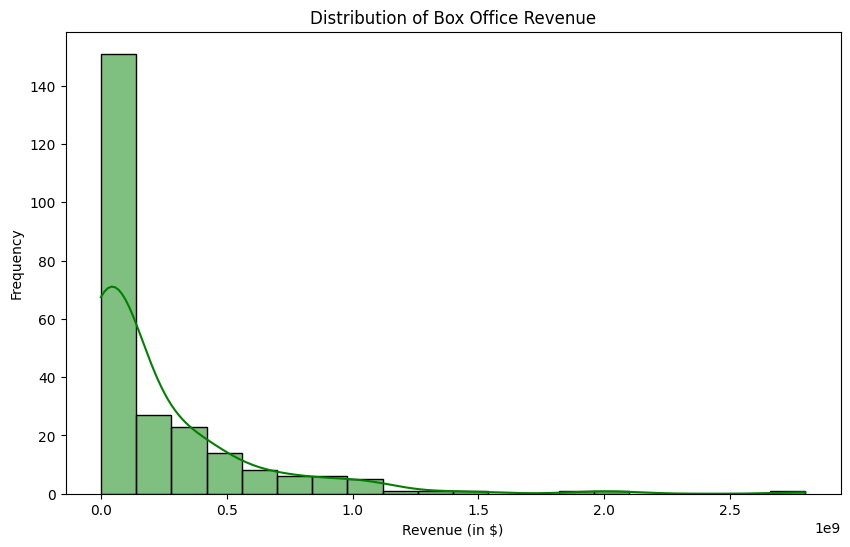

In [20]:
# Histogram of Box Office Revenue
plt.figure(figsize=(10, 6))
sns.histplot(df['Box Office Revenue'], bins=20, kde=True, color='green')
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Revenue (in $)")
plt.ylabel("Frequency")
plt.show()

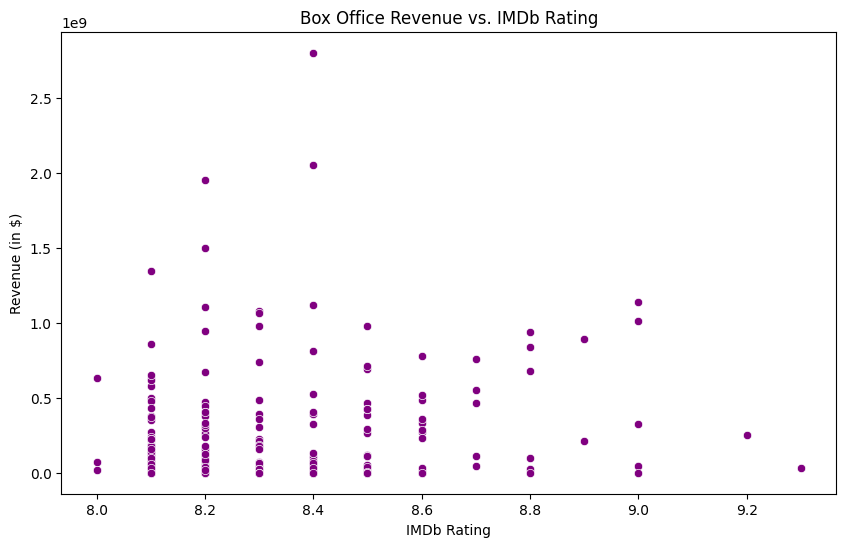

In [27]:
# Scatter plot of Revenue vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IMDb Rating', y='Box Office Revenue', data=df, color='purple')
plt.title("Box Office Revenue vs. IMDb Rating")
plt.xlabel("IMDb Rating")
plt.ylabel("Revenue (in $)")
plt.show()

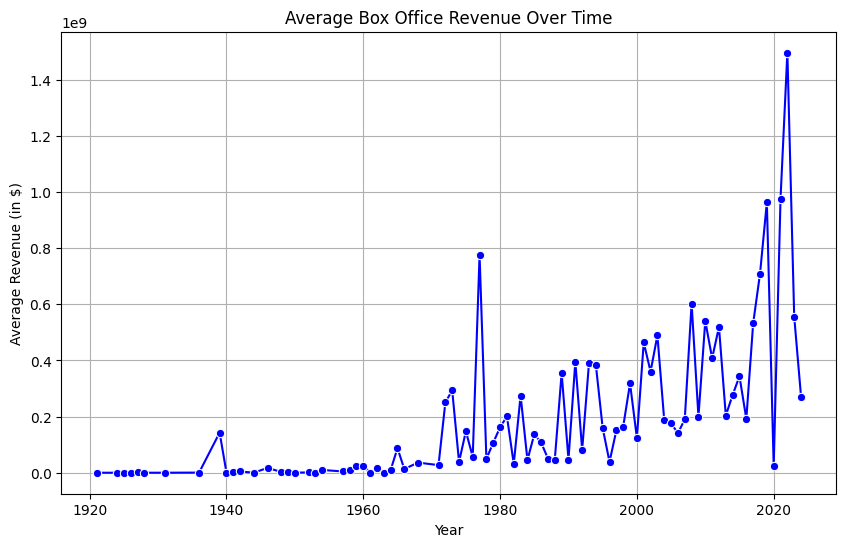

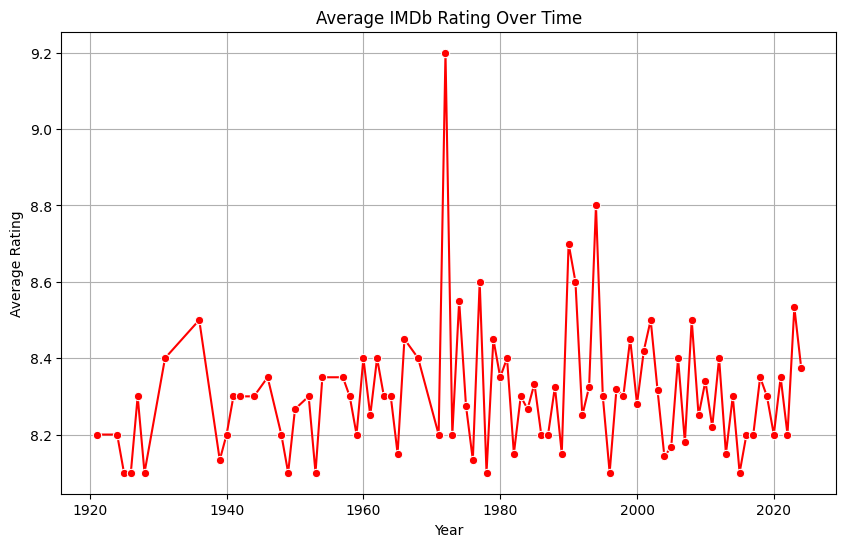

In [28]:
# Group by Year and calculate mean revenue and rating
trends = df.groupby('Year').agg({
    'Box Office Revenue': 'mean',
    'IMDb Rating': 'mean'
}).reset_index()

# Line plot for average revenue over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Box Office Revenue', data=trends, marker='o', color='blue')
plt.title("Average Box Office Revenue Over Time")
plt.xlabel("Year")
plt.ylabel("Average Revenue (in $)")
plt.grid(True)
plt.show()

# Line plot for average rating over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='IMDb Rating', data=trends, marker='o', color='red')
plt.title("Average IMDb Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

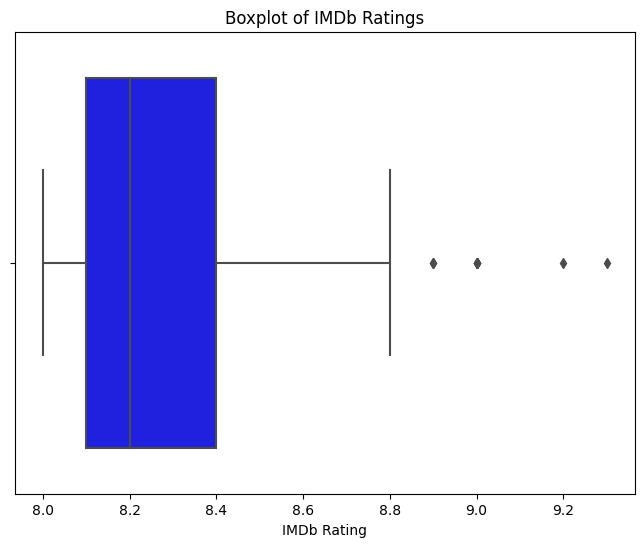

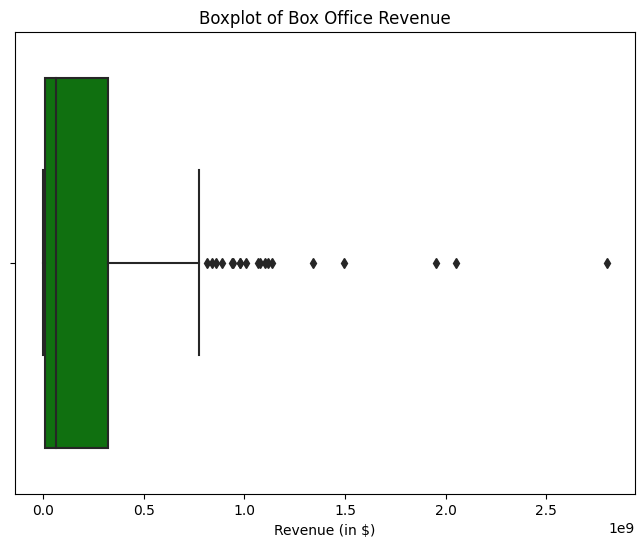

In [29]:
# Boxplot for IMDb Ratings
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['IMDb Rating'], color='blue')
plt.title("Boxplot of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.show()

# Boxplot for Box Office Revenue
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Box Office Revenue'], color='green')
plt.title("Boxplot of Box Office Revenue")
plt.xlabel("Revenue (in $)")
plt.show()

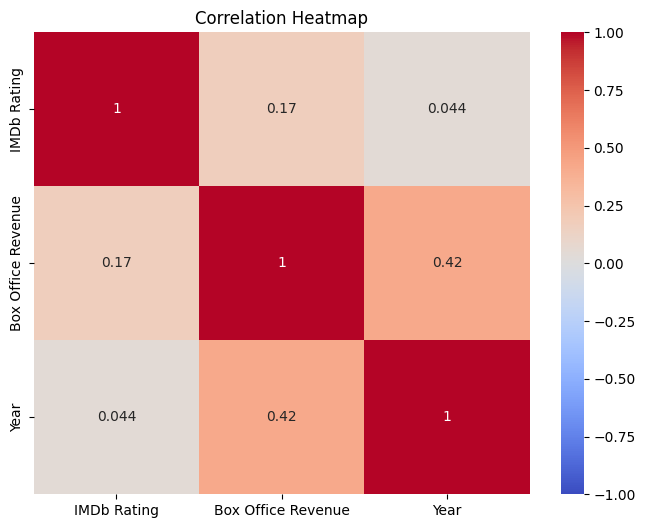

In [30]:
# Calculate correlation matrix
corr_matrix = df[['IMDb Rating', 'Box Office Revenue', 'Year']].corr()

# Heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

c:\Users\ASUS\Lasitha\MSC Data Science\Programming for DS\Assignment\EDA-For-IMDbFilms\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


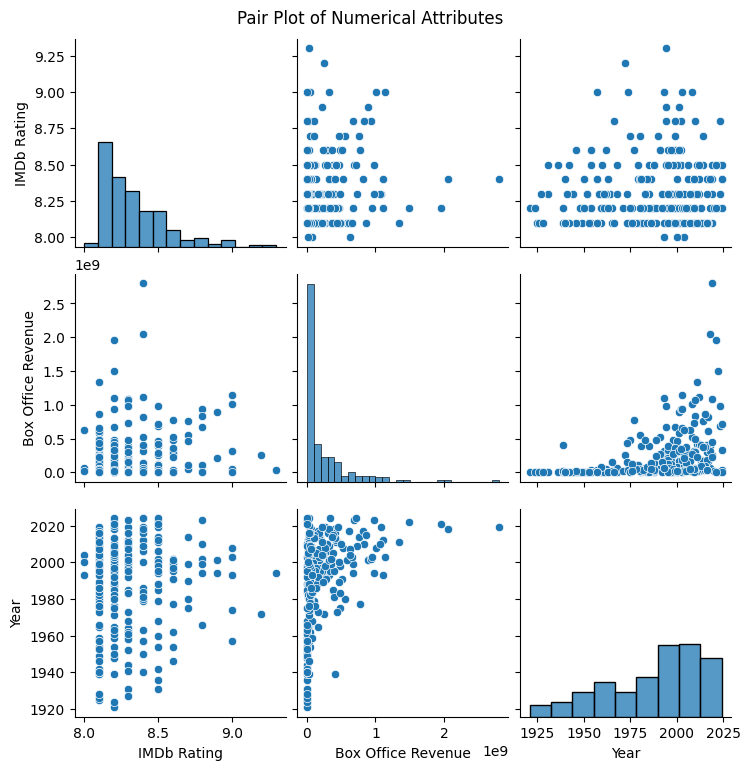

In [31]:
# Pair plot
sns.pairplot(df[['IMDb Rating', 'Box Office Revenue', 'Year']])
plt.suptitle("Pair Plot of Numerical Attributes", y=1.02)
plt.show()